In [15]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

from astropy.io import fits
from astropy import wcs

import sys
import imp
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils
imp.reload(cat_utils)
from scipy.optimize import curve_fit
import scipy

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

In [16]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '../zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# CIBER's measurements are of \lambda*I_\lambda, which can be converted to I_f by dividing by f 
# see https://www.evernote.com/shard/s316/nl/2147483647/1d5cc7be-446f-4933-9450-629dd63020c4/
convert_to_kJy_per_sr = 1.e-9/(3.e8/1.1e-6)/(1.e3*1.e-26)
print(convert_to_kJy_per_sr)

ciber_ell = ell_Cell_ciber[1::3,0]
ciber_dell = ciber_ell[1:]-ciber_ell[:-1]
ciber_delta = ell_Cell_ciber[1::3,1]*convert_to_kJy_per_sr
ciber_ddelta_plus = np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1])*convert_to_kJy_per_sr
ciber_ddelta_minus = np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])*convert_to_kJy_per_sr
ciber_ddelta = (ciber_ddelta_plus+ciber_ddelta_minus)/2.+1.e-3

eormodel_ell = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr
eormodel_delta = ell_Cell_eormodel[:,1]*convert_to_kJy_per_sr

0.366666666667


In [17]:
g = (ciber_ell>500)&(ciber_ell<2300)
ciber_ell[g],ciber_dell[g]

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19 but corresponding boolean dimension is 20
  from ipykernel import kernelapp as app


(array([  592.66269736,   831.33456303,  1183.19133522,  1635.35238825,
         2261.35979898]),
 array([ 238.67186567,  351.85677219,  452.16105303,  626.00741073,
         864.18721769]))

In [18]:
ciber_delta[g]/convert_to_kJy_per_sr

array([ 2.98796061,  2.45378737,  1.42316056,  1.57462726,  1.92427965])

In [19]:
np.sum(ciber_dell[np.where(g)[0]]*ciber_delta[g])/np.sum(ciber_dell[np.where(g)[0]])/convert_to_kJy_per_sr

1.9221911519071804

In [20]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I', \
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I']

analysis_names = ['_'.join([l.split('o')[1] for l in labelgroup.split()]) for labelgroup in label_groups]
print(analysis_names)

run = 'ATLAS_mwa57694_rereduction'
xcor_data_dir = '/home/abrahamn/xcor_data/'
raw_frames_root = xcor_data_dir+run+'/'
analysis_roots = [xcor_data_dir+'analysis/'+run+'/' + a + '/' for a in analysis_names]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']
['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [22]:
analysis_roots[i]+analysis_names[i]+'_secat_best_magoffset=0.274.p'

'/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I_secat_best_magoffset=0.274.p'

In [23]:
secats = []
for i in range(4):
#     secat = cat_utils.IRCatalog(se_path=analysis_roots[i]+analysis_names[i]+'.sex',se_magzpt=20.46)
    secat = pickle.load(open( analysis_roots[i]+analysis_names[i]+'_secat_best_magoffset=0.274.p', "rb" ) )
    g = secat.jy_all>1.e-10
    secat = cat_utils.Catalog(secat.ra_all[g],secat.dec_all[g],secat.jy_all[g],a=secat.a[g],b=secat.b[g])
    
    secats.append(secat)

(2.7401479326601912, -24.789017138633387)
(357.24780231196945, -24.689997090704114)
(2.8473810974648135, -29.130555545466265)
(357.1338790636421, -29.228966964566052)


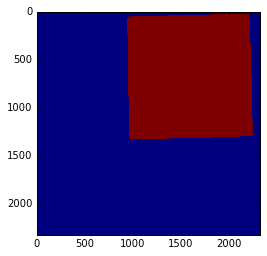

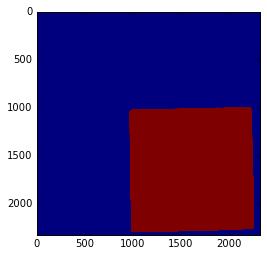

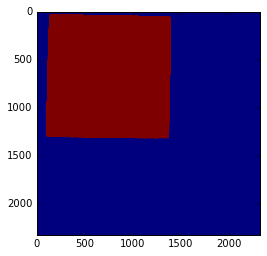

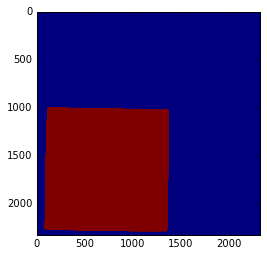

In [24]:
imgs = []
ws = []
x_meds = []
y_meds = []
racents = []
deccents = []

for i in range(4):
    img_fits_path = analysis_roots[i]+analysis_names[i]+'.fits'

    hdulist_img = fits.open(img_fits_path)
    img = hdulist_img[0].data
    h = hdulist_img[0].header
    n = img.shape[0]
    hdulist_img.close()
    w = wcs.WCS(h)
    asec_per_pixel = np.abs(h['CD1_1'])*3600
    
    plt.figure()
    plt.imshow(img[::10,::10]>0)

    x,y = np.where(img != 0)
    x_med, y_med = int(np.median(x)),int(np.median(y))
    
    radeccent = w.wcs_pix2world(x_med,y_med,0)
    racent,deccent = 1.*radeccent[0],1.*radeccent[1]
    print(racent,deccent)
    
    imgs.append(img)
    ws.append(w)
    x_meds.append(x_med)
    y_meds.append(y_med)
    racents.append(racent)
    deccents.append(deccent)

In [25]:
def mask_circle_in_image(m,xcent,ycent,r):    
    if r == 0: return
    
    n=m.shape[0]
    if not ((0<=xcent<n) and (0<=ycent<n)): return
    for y in range(-int(r),int(r)+1): # x is the x distance from circle center
        if not (0 <= ycent+y < n): continue
        #print(n)
        #print(int(xcent-np.sqrt(r**2-y**2)),int(xcent+np.sqrt(r**2-y**2)))
        #rint(max(0,int(xcent-np.sqrt(r**2-y**2))),min(n,int(xcent+np.sqrt(r**2-y**2))),)
        m[ycent+y,max(0,int(xcent-np.sqrt(r**2-y**2))):min(n,int(xcent+np.sqrt(r**2-y**2)))] = 0
        
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked=.5,gauss_fit_min=.1,bin_method='fit'): # or 'avg'
    img_binned = np.zeros((n_coarse,n_coarse))
    
    binedges = np.linspace(300,400,200) # for the hist gaussian fitting
    
    print(bin_method)
    
    for i in range(n_coarse):
        if i % 15 == 0: print('%1.3f '%(1.*i/n_coarse)),
        for j in range(n_coarse):
            img_in_this_coarse_bin = img[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            mask_in_this_coarse_bin = mask[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            if np.any(img_in_this_coarse_bin==0) or np.sum(mask_in_this_coarse_bin)<min_fraction_unmasked*coarse_bin_factor**2: continue

            unmasked_img_vals = img_in_this_coarse_bin[1==mask_in_this_coarse_bin]
                
            if bin_method == 'avg':
                img_binned[i,j] = np.mean(unmasked_img_vals)
            elif bin_method == 'fit':
                counts,binedges = np.histogram(unmasked_img_vals,binedges)
                bins = .5*(binedges[1:]+binedges[:-1])
                g = counts>np.max(counts)*gauss_fit_min

                try:
                    coeff, var_matrix = curve_fit(gauss, bins[g], counts[g],\
                                                  p0=[np.max(counts),np.median(img_in_this_coarse_bin[1==mask_in_this_coarse_bin]),10],\
                                                  sigma=np.sqrt(counts[g]))
                    img_binned[i,j] = coeff[1]
                except:
                    pass
    return img_binned

In [26]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def vec2arr(v):
    return np.array(v).flatten()

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False,filt_small_lx_and_ly_bins=False):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    dl = np.abs(lvals[1]-lvals[0])
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))
    ft_mask = (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= ft_mask
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optPS(img_meas,pguess_method,dtheta_rad,nbins,lmin,lmax,uselogbins=True,interp_pguess=False,verbose=False,filt_small_lx_and_ly_bins=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                smallell = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&smallell),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
    print('a '),
    # generate the fourier transform matrix
    lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
    
    if pguess_method == 'zemcov':
        pguess = np.interp(lbincenters,ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1]**2/ell_Cell_ciber[1::3,0]**2)
    else:
        pguess = 1./lbincenters**pguess_method
    
    Cguess_ft = matrix(np.diag( 10.**np.interp(np.log10(lmaggrid.flatten()),np.log10(lbincenters),np.log10(pguess/norm/n**2)) ))   
    Csignal = F*Cguess_ft*conj(F).T
            
    print('c '),
    Cmask = 1.e5*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
    print('d '),
    Cinv = inv(Csignal + Cmask)

    print('e '),
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('\nbins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p0,Fish

In [27]:
def rawimg2pspec(img,w,analysis_name,secat,mask_coef1=10,mask_coef2=12,mask_above_median_adu_plus=1.e9,\
             target_coarse_res_amin=3.5,min_fraction_unmasked=.5,gauss_fit_min=.1,\
             fov_deg=4.,ps_method='oqe',filt_small_lx_and_ly_bins=True,lmin=350,lmax=4360,nbins=8,\
             uselogbins=True,use_fft_hann=False,masked_img_zoom_skip=1,bin_method='avg',pguess_method='zemcov',\
                 max_adu=25000.,mask_rad_asec_around_max_adu=400.,only_compute_masking_stats=False):
    
    params = {'analysis_name':analysis_name,\
             'mask_coef1':mask_coef1,\
             'mask_coef2':mask_coef2,\
             'mask_above_median_adu_plus':mask_above_median_adu_plus,\
             'target_coarse_res_amin':target_coarse_res_amin,\
             'min_fraction_unmasked':min_fraction_unmasked,\
             'gauss_fit_min':gauss_fit_min,\
             'fov_deg':fov_deg,\
             'ps_method':ps_method,\
             'filt_small_lx_and_ly_bins':filt_small_lx_and_ly_bins,\
             'lmin':lmin,\
             'lmax':lmax,\
             'nbins':nbins,\
             'uselogbins':uselogbins,\
             'use_fft_hann':use_fft_hann,\
             'masked_img_zoom_skip':masked_img_zoom_skip,\
             'bin_method':bin_method,
             'pguess_method':pguess_method,\
             'max_adu':max_adu,\
             'mask_rad_asec_around_max_adu':mask_rad_asec_around_max_adu}
    
    mask = np.ones(img.shape)
    px,py = w.wcs_world2pix(secat.ra,secat.dec,1)

    print('masking sources')
    for i in range(len(secat.ra)):
        if i % 2500 == 0: print('%1.3f '%(1.*i/len(secat.ra))),
        mask_circle_in_image(mask,px[i],py[i],mask_coef1*secat.jy[i]/asec_per_pixel+mask_coef2*min(secat.a[i],secat.b[i]))
    
    print('\nmasking around nearly saturated pixels')
    xbad,ybad = np.where(img>max_adu)
    for i in range(len(xbad)):
        if i % 2500 == 0: print('%1.3f '%(1.*i/len(xbad))),
        mask_circle_in_image(mask,ybad[i],xbad[i],mask_rad_asec_around_max_adu/asec_per_pixel)
    
    mask *= img < mask_above_median_adu_plus + np.median(img[img>0]) # to active this, set mask_above_median_adu_plus = 10    
    
    mask_stats = []
    if only_compute_masking_stats:
        mask_stats.append(100.*np.sum(img>65000)/np.sum(img>0))
        mask_stats.append(100.*np.sum(img>max_adu)/np.sum(img>0))
        mask_stats.append(100.*np.sum(mask==0)/np.sum(img>0))
    
    dd = 300
    x,y = np.where(img != 0)
    x_med, y_med = int(np.median(x)),int(np.median(y))
    x0,x1 = x_med-dd,x_med+dd
    y0,y1 = y_med-dd,y_med+dd
    skip = masked_img_zoom_skip
    masked_img_zoom = img[x0:x1:skip,y0:y1:skip]*mask[x0:x1:skip,y0:y1:skip]
    target_coarse_res_asec = target_coarse_res_amin*60.
    fine_pixel_asec = 1.86
    coarse_bin_factor = int(np.round(target_coarse_res_asec/fine_pixel_asec))
    dtheta_coarse_rad = fine_pixel_asec*coarse_bin_factor/3600*np.pi/180
    params['actual_coarse_res_amin'] = fine_pixel_asec/60*coarse_bin_factor
    params['coarse_bin_factor'] = coarse_bin_factor
    
    n_coarse = int(np.floor(1.*n/coarse_bin_factor))
    
    n_fine_max = n_coarse*coarse_bin_factor
    print('n_coarse = %d, coarse_bin_factor = %d'%(n_coarse,coarse_bin_factor))
    
    print('binning image')
    img_coarse = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked,gauss_fit_min,bin_method=bin_method)
    
    d = int(fov_deg*np.pi/180/dtheta_coarse_rad)
    dtheta_rad = fine_pixel_asec/3600*np.pi/180
    x0 = int(x_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    x1 = x0+d
    y0 = int(y_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    y1 = y0+d
    
    params['x0'],params['x1'],params['y0'],params['y1'] = x0,x1,y0,y1
    params['n_frame'] = d

    magzpt,exp_time_sec = 20.56+0.274,30
    params['magzpt'] = magzpt
    adu2jy_per_sr = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_coarse_rad**2*coarse_bin_factor**2

    img_kjy_per_sr = adu2jy_per_sr*img_coarse
    img_kjy_per_sr_crop = np.array(img_kjy_per_sr[x0:x1,y0:y1])
    img_kjy_per_sr_meansub_crop = np.array(img_kjy_per_sr_crop)
    img_kjy_per_sr_meansub_crop[img_kjy_per_sr_meansub_crop!=0] -= np.mean(img_kjy_per_sr_meansub_crop[img_kjy_per_sr_meansub_crop!=0])

    
    
    mask_stats.append(100.*np.sum(img_kjy_per_sr_meansub_crop==0)/np.sum(img_kjy_per_sr_meansub_crop>=0))
    
    lbins=None
    pspec=None
    if ps_method == 'fft':
        lbins,pspec,bin_counts = img2PS(img_kjy_per_sr_meansub_crop,dtheta_coarse_rad,nbins,lmin,lmax,\
                                         uselogbins=True,usehann=use_fft_hann,\
                                         filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)    
    elif ps_method == 'oqe':
        lbins,pspec,Fish = img2optPS(img_kjy_per_sr_meansub_crop,pguess_method,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=uselogbins,interp_pguess=True,verbose=True,\
                                  filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)
    
    print('done')
    return {'lbins':lbins,'pspec':pspec,'img_kjy_per_sr_crop':img_kjy_per_sr_crop,\
            'masked_img_zoom':masked_img_zoom,'params':params,'img_kjy_per_sr':img_kjy_per_sr}

In [28]:
# # run image masking and power spectrum estimation

# d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'

# max_adu = 45000
# mask_rad_asec_around_max_adu = 250
# target_coarse_res_amin=6
# for i in range(4):
#     masked_img_dat = rawimg2pspec(imgs[i],ws[i],analysis_names[i],secats[i],mask_coef1=0,mask_coef2=12,mask_above_median_adu_plus=10.,\
#                     min_fraction_unmasked=.2,ps_method='none',filt_small_lx_and_ly_bins=True,\
#                     max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu,target_coarse_res_amin=target_coarse_res_amin,fov_deg=3.9)
    
#     pickle.dump( masked_img_dat, open( d+analysis_names[i]+'_'+str(target_coarse_res_amin)+"amin.p", "wb" ) )

In [29]:
# run image masking and power spectrum estimation

nbins = 8

lbins_pspec_img_zoom_list = [[],[],[],[]]
max_adu = 45000
mask_rad_asec_around_max_adu = 250
for i in range(4):
    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],analysis_names[i],secats[i],mask_coef1=0,mask_coef2=0,mask_above_median_adu_plus=1.e9,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],analysis_names[i],secats[i],mask_coef1=0,mask_coef2=5,mask_above_median_adu_plus=1.e9,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],analysis_names[i],secats[i],mask_coef1=0,mask_coef2=12,mask_above_median_adu_plus=10.,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],analysis_names[i],secats[i],mask_coef1=0,mask_coef2=12,mask_above_median_adu_plus=10.,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=True,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))
    
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
pickle.dump( lbins_pspec_img_zoom_list, open( d+"lbins_pspec_img_zoom_list_4frames_magoffset=20.56+0.274.p", "wb" ) )

masking sources
0.000  0.049  0.098  0.147  0.197  0.246  0.295  0.344  0.393  0.442  0.491  0.540  0.590  0.639  0.688  0.737  0.786  0.835  0.884  0.934  0.983  
masking around nearly saturated pixels
0.000  0.211  0.423  0.634  0.845  n_coarse = 205, coarse_bin_factor = 113
binning image
avg
0.000  0.073  0.146  0.220  0.293  0.366  0.439  0.512  0.585  0.659  0.732  0.805  0.878  0.951  
dl = 90
44 cells in \ell=414.9 bin
80 cells in \ell=568.6 bin
136 cells in \ell=779.4 bin
288 cells in \ell=1068.3 bin
500 cells in \ell=1464.2 bin
968 cells in \ell=2007.0 bin
1754 cells in \ell=2750.9 bin
808 cells in \ell=3770.5 bin
a 

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:95: RuntimeWarning: divide by zero encountered in log10


 c  d  e  
bins:  0 1 2 3 4 5 6

KeyboardInterrupt: 

In [85]:
labels = ['Mask 4\' around saturated pixels','& Mask sources to 5$\sigma$','& Mask sources to 12$\sigma$ and >100kJy/sr','& exclude $|\ell_x|,|\ell_y|<200$' ]

masking_stats = np.array(lbins_pspec_img_zoom_list)

for i in range(4):
    print(analysis_names[i])
    for j in range(4):
        print('%-50s'%labels[j]),
        for k in range(4):
            print('%1.5f '%masking_stats[i,j,k]),
        print
    print('\n')

0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I
Mask 4' around saturated pixels                    0.00064  0.00727  13.87819  7.30969 
& Mask sources to 5$\sigma$                        0.00064  0.00727  19.13882  7.33131 
& Mask sources to 12$\sigma$ and >100kJy/sr        0.00064  0.00727  47.10545  8.00173 
& exclude $|\ell_x|,|\ell_y|<200$                  0.00064  0.00727  47.10545  8.00173 


0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I
Mask 4' around saturated pixels                    0.00028  0.00534  13.79579  7.46107 
& Mask sources to 5$\sigma$                        0.00028  0.00534  19.24692  7.56920 
& Mask sources to 12$\sigma$ and >100kJy/sr        0.00028  0.00534  47.69048  8.08824 
& exclude $|\ell_x|,|\ell_y|<200$                  0.00028  0.00534  47.69048  8.08824 


0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I
Mask 4' around saturated pixels                    0.00108  0.00963  14.99135  8.91003 
& Mask sources to 5$\sigma$               

In [86]:
for j in range(4):
    print('%-50s'%labels[j]),
    for k in range(4):
        print('%1.5f '%(100.-np.mean(masking_stats[:,j,k]))),
    print
print('\n')

Mask 4' around saturated pixels                    99.99940  99.99263  85.82290  92.14425 
& Mask sources to 5$\sigma$                        99.99940  99.99263  80.80315  92.06856 
& Mask sources to 12$\sigma$ and >100kJy/sr        99.99940  99.99263  53.96056  91.44680 
& exclude $|\ell_x|,|\ell_y|<200$                  99.99940  99.99263  53.96056  91.44680 




In [9]:
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
lbins_pspec_img_zoom_list = pickle.load(open( d+"lbins_pspec_img_zoom_list_4frames_2.p", "rb" ) )
#lbins_pspec_img_zoom_list = pickle.load(open( d+"lbins_pspec_img_zoom_list_4frames_1.p", "rb" ) )

In [10]:
lbins_pspec_img_zoom_list[0][0][4]

{'analysis_name': '0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I',
 'bin_method': 'avg',
 'filt_small_lx_and_ly_bins': False,
 'fov_deg': 4.0,
 'gauss_fit_min': 0.1,
 'lmax': 4360,
 'lmin': 350,
 'mask_above_median_adu_plus': 1000000000.0,
 'mask_coef1': 0,
 'mask_coef2': 0,
 'mask_rad_asec_around_max_adu': 250,
 'masked_img_zoom_skip': 1,
 'max_adu': 45000,
 'min_fraction_unmasked': 0.1,
 'nbins': 8,
 'pguess_method': 'zemcov',
 'ps_method': 'oqe',
 'target_coarse_res_amin': 3.5,
 'use_fft_hann': False,
 'uselogbins': True}

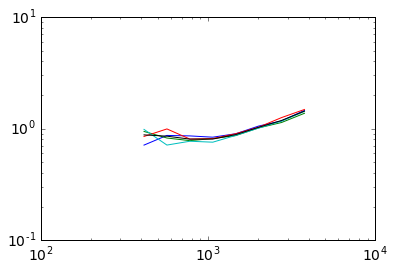

In [43]:
lbins = lbins_pspec_img_zoom_list[0][0][0]
for i in range(4):
    plt.loglog(lbins,sqrt(lbins**2*lbins_pspec_img_zoom_list[i][3][1]/(2*pi)))
    
mean_best_fg_sub_over_all_fields = np.mean(np.array(lbins_pspec_img_zoom_list)[:,3,1])
plt.loglog(lbins,sqrt(lbins**2*mean_best_fg_sub_over_all_fields/(2*pi)),'k-')

In [38]:
lbins[1:6]

array([  568.63451811,   779.40022166,  1068.28672227,  1464.24967464,
        2006.97721406])

In [45]:
dlbins = lbins[1:]-lbins[:-1]
dlbins

array([  153.77036206,   210.76570355,   288.88650061,   395.96295237,
         542.72753942,   743.89076121,  1019.61559791])

In [53]:
vals = np.array([np.sum(dlbins[1:6]*sqrt(lbins[1:6]**2/(2*np.pi)*lbins_pspec_img_zoom_list[i][3][1][1:6]))/np.sum(dlbins[1:6]) for i in range(4)])

print(np.mean(vals),np.std(vals))
conv = 1.e-9/(3.e8/0.85e-6)/(1.e3*1.e-26)
print(np.mean(vals)/conv,np.std(vals)/conv)

(0.90420519479107986, 0.025823099181402562)
(3.1913124522038112, 0.091140350052009045)


In [ ]:
stys = ['r.:','c.--','y.-','bs-']
lws = [1,1,1,1]
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(6,7))
labels = ['1. Mask 4\' around saturated pixels','2. Mask sources to 5$\sigma$','3. Mask sources to 12$\sigma$ and >100kJy/sr','4. Exclude $|\ell_x|,|\ell_y|<200$' ]

for framei in range(4):
    for j in range(4):
        l = labels[j] if framei == 0 else ''
        lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom,params = lbins_pspec_img_zoom_list[framei][j]
        plt.loglog(lbins,sqrt(lbins**2*pspec/(2*pi)),stys[j],label=l,linewidth=lws[j])

plt.errorbar(ciber_ell,ciber_delta,yerr=[ciber_ddelta_plus,ciber_ddelta_minus],fmt='o',label='CIBER 1.1um',color='k')

plt.loglog(eormodel_ell,eormodel_delta,'k:',label='EOR theory')

plt.legend(fontsize=11,loc=(.3,.08))
plt.ylim([.01,200])
plt.xlim([300,1.e4])
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel('$\Delta(\ell)$ (kJy/sr)',fontsize=16)

plt.savefig('big_foreground_masking_study_pspecs_2_magoffset=20.56+0.274.pdf',bbox_inches='tight')
#plt.savefig('big_foreground_masking_study_pspecs_1.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(14,15))

magzpt,exp_time_sec = 20.56,30
dtheta_rad = asec_per_pixel/3600.*np.pi/180
adu2kjy_per_sr = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_rad**2

transFigure = fig.transFigure.inverted()

axes = [[],[],[],[]]

for j in range(4):
    lbins,pspec,img_kjy_per_sr,masked_img_zoom,params = lbins_pspec_img_zoom_list[0][j]
        
    plt.subplot(4,3,3*j+1)
    axes[j].append(plt.gca())
    d = 300
    masked_img_zoom_nanned = array(masked_img_zoom)
    masked_img_zoom_nanned[masked_img_zoom_nanned==0] = np.nan
    plt.imshow(adu2kjy_per_sr*masked_img_zoom_nanned[0:d,300:300+d]/1.e3,interpolation='nearest',cmap='jet',rasterized=True,\
              vmin=3.1,vmax=3.5,extent=[-asec_per_pixel/60*d/2,asec_per_pixel/60*d/2,-asec_per_pixel/60*d/2,asec_per_pixel/60*d/2])
    cbar = plt.colorbar()
    cbar.set_ticks(3.1+.1*np.arange(5))
    plt.ylabel('$\\theta_y$ (arcmin)',fontsize=16)
    if j == 3: plt.xlabel('$\\theta_x$ (arcmin)',fontsize=16)
    if j == 0: plt.title('Zoom in on 9\' field\n 1.86\'\' resolution ($10^3$ kJy/sr)',fontsize=14)
    
    ###################################################
    plt.subplot(4,3,3*j+2)
    axes[j].append(plt.gca())
    n_coarse = img_kjy_per_sr.shape[0]
    dtheta_coarse_amin = 3.5
    dtheta_coarse_rad = dtheta_coarse_amin/60.*np.pi/180
    img_kjy_per_sr_nanned = array(img_kjy_per_sr)
    img_kjy_per_sr_nanned[img_kjy_per_sr_nanned==0] = np.nan
    plt.imshow(img_kjy_per_sr_nanned/1.e3,interpolation='nearest',cmap='jet',vmin=3.225,vmax=3.3,rasterized=True,\
              extent=[-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2,-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    cbar = plt.colorbar()
    cbar.set_ticks(3.2+.025*np.arange(8))
    if j == 3: plt.xlabel('$\\theta_x$ (arcmin)',fontsize=16)
    if j == 0: plt.title('Whole 4 deg field,\n 3.5\' resolution ($10^3$ kJy/sr)',fontsize=14)

    dy = 1.25*dtheta_coarse_amin
    plt.plot(np.array([-1.5*dtheta_coarse_amin,-1.5*dtheta_coarse_amin,1.5*dtheta_coarse_amin,1.5*dtheta_coarse_amin,-1.5*dtheta_coarse_amin]),\
            np.array([-1.5*dtheta_coarse_amin,1.5*dtheta_coarse_amin,1.5*dtheta_coarse_amin,-1.5*dtheta_coarse_amin,-1.5*dtheta_coarse_amin])+2*dy,'k',linewidth=2)
    plt.xlim([-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    plt.ylim([-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    
    ###################################################
    plt.subplot(4,3,3*j+3)
    axes[j].append(plt.gca())
    pspec_norm = (dtheta_coarse_rad**2)/(n_coarse**2)
    img_kjy_per_sr_meansub = array(img_kjy_per_sr)
    img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])
    pspec2d = np.abs(np.fft.fft2(img_kjy_per_sr_meansub))**2*pspec_norm
    
    lvals = fft.fftfreq(n_coarse)*2*pi/dtheta_coarse_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)
    delta = np.fft.fftshift(sqrt(lmaggrid**2*pspec2d/(2*pi)))
    
    if j == 3: delta *= 1.*np.fft.fftshift((np.abs(lxgrid)>2*dl)*(np.abs(lygrid)>2*dl))
    
    plt.imshow(np.log10(delta),vmin=-1,vmax=2,rasterized=True,\
               interpolation='nearest',cmap='jet',extent=[-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3,-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])
    if j == 0: plt.title('Fourier transform of whole\n 4 deg field (log $\Delta(\ell_x,\ell_y)}$/(kJy/sr))',fontsize=14)
    plt.ylabel('$1000\\times\ell_y$',fontsize=16)
    if j == 3: plt.xlabel('$1000\\times\ell_x$',fontsize=16)
    plt.colorbar()
    
        
    plt.xlim([-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])
    plt.ylim([-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])

plt.tight_layout()

for j in range(4):
    [i.set_linewidth(2) for i in axes[j][0].spines.itervalues()]
    
    coord1 = transFigure.transform(axes[j][0].transData.transform([4.65,4.35]))
    coord2 = transFigure.transform(axes[j][1].transData.transform([-3,14]))
    line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),transform=fig.transFigure,linewidth=2,color='k')
    fig.lines.append(line)

    coord1 = transFigure.transform(axes[j][0].transData.transform([4.65,-4.35]))
    coord2 = transFigure.transform(axes[j][1].transData.transform([-3,3]))
    line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),transform=fig.transFigure,linewidth=2,color='k')
    fig.lines.append(line)
    

plt.savefig('big_foreground_masking_study_2_magoffset=20.56+0.274.pdf',bbox_inches='tight')
#plt.savefig('big_foreground_masking_study_1.pdf',bbox_inches='tight')

In [147]:
10*adu2kjy_per_sr

88.864719034976289

In [148]:
dl

90.756302521008394